In [1]:
import numpy as np
import glob, os, json

import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [2]:
# import the par and tim files
datadir = './data12.5yr/partim/'

parfiles = sorted(glob.glob(datadir + '*.par'))
timfiles = sorted(glob.glob(datadir + '*v3.tim'))

psrs = []
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    psr = Pulsar(p, t, ephem='DE438')
    psrs.append(psr)

In [3]:
## Get parameter noise dictionary
noisedir = os.getcwd() + '/data12.5yr/partim/'

noise_params = {}
for filepath in glob.iglob(noisedir + '/*maxlike.json'):
    with open(filepath, 'r') as f:
        noise_params.update(json.load(f))
# print(noise_params)

In [4]:
common_rn = noise_params['gw_log10_A']
print(common_rn)
F_YR = 1 / 31557600  # frequency of a year
print(F_YR)
common_gamma = 13/3
f = np.logspace(-10, -5, num=1000)
S = (10**common_rn)**2 / (12 * np.pi) * (f / F_YR)**(-common_gamma) * F_YR**(-3)

-14.78361797461833
3.168808781402895e-08


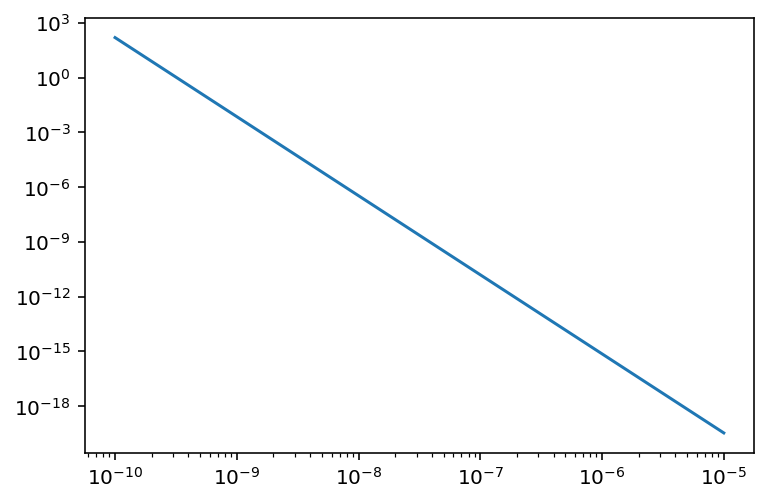

In [5]:
plt.loglog(f, S)

## FFT TOA data

In [6]:
t = psrs[0].toas / 86400
res = psrs[0].residuals

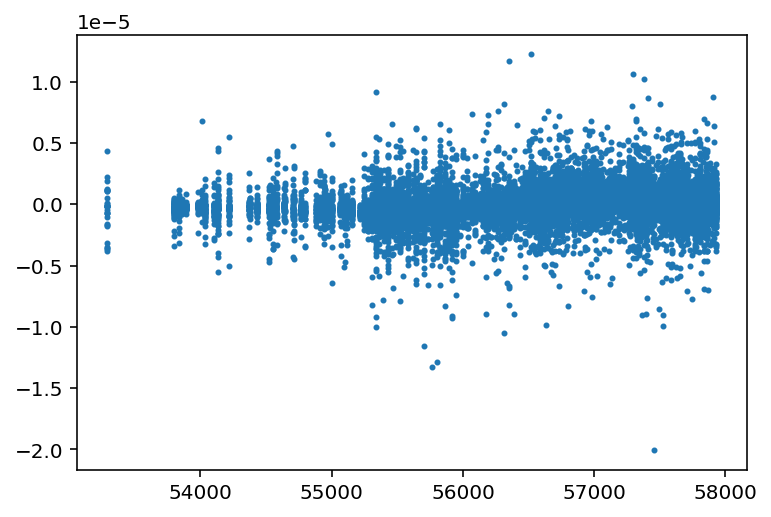

In [7]:
plt.plot(t, res, 'o', markersize=2)

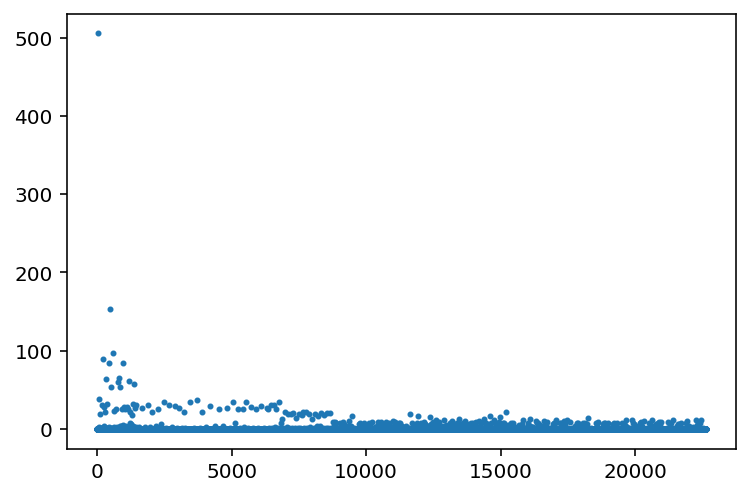

In [8]:
# average spacing between points
dt = np.diff(t)
# print(np.mean(dt))
plt.plot(dt, 'o', markersize=2)

In [9]:
def dft(t, X, f):
    """
    Performs Discrete Fourier Transform (DFT) on arbitrary time samples with frequencies f.

    t: time vector of length n
    X: samples vector of length n
    f: frequency vector of length m

    Does not require f and X to have the same dimension.
    t and X should have the same length though.
    """
    Y = np.zeros(len(f))
    omega_jk = np.exp(np.outer(f, -2 * np.pi * 1j * t))
    Y = np.matmul(omega_jk, X)
    return Y

In [28]:
t = psrs[0].toas
T = np.max(t) - np.min(t)
flow = 1 / T
# flow_10 = np.log10(flow)
fhigh = 1 / (14 * 86400)
print(flow)
print(fhigh)
res = psrs[0].residuals
# f = np.logspace(flow_10, -5, num=1000)
f = np.linspace(flow, fhigh, 999)
f = np.sort(np.insert(f, 0, F_YR))
print(f)

2.4963946862525665e-09
8.267195767195768e-07
[2.49639469e-09 3.32226962e-09 4.14814455e-09 4.97401948e-09
 5.79989441e-09 6.62576935e-09 7.45164428e-09 8.27751921e-09
 9.10339414e-09 9.92926907e-09 1.07551440e-08 1.15810189e-08
 1.24068939e-08 1.32327688e-08 1.40586437e-08 1.48845187e-08
 1.57103936e-08 1.65362685e-08 1.73621435e-08 1.81880184e-08
 1.90138933e-08 1.98397683e-08 2.06656432e-08 2.14915181e-08
 2.23173931e-08 2.31432680e-08 2.39691429e-08 2.47950178e-08
 2.56208928e-08 2.64467677e-08 2.72726426e-08 2.80985176e-08
 2.89243925e-08 2.97502674e-08 3.05761424e-08 3.14020173e-08
 3.16880878e-08 3.22278922e-08 3.30537672e-08 3.38796421e-08
 3.47055170e-08 3.55313920e-08 3.63572669e-08 3.71831418e-08
 3.80090168e-08 3.88348917e-08 3.96607666e-08 4.04866416e-08
 4.13125165e-08 4.21383914e-08 4.29642663e-08 4.37901413e-08
 4.46160162e-08 4.54418911e-08 4.62677661e-08 4.70936410e-08
 4.79195159e-08 4.87453909e-08 4.95712658e-08 5.03971407e-08
 5.12230157e-08 5.20488906e-08 5.2874765

In [29]:
Y = dft(t, res, f)
print(len(Y))

1000


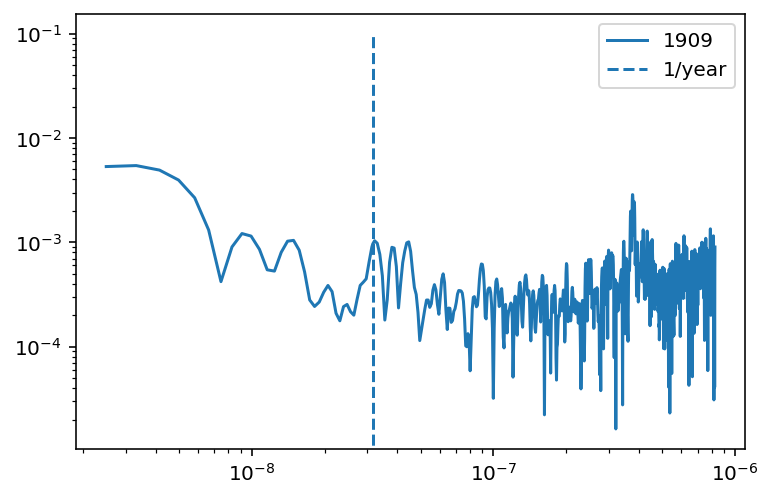

In [35]:
plt.loglog(f, np.abs(Y), label='1909')
plt.vlines(1 / 31557600, ymin=0, ymax=1e-1, linestyle='dashed', label='1/year')
plt.legend()
plt.savefig('dft1909.png', dpi=400, bbox_inches='tight')